# Proof of concept model

Обучим сетку решать похожую задачу на модельных данных. 

Данные трех типов - гипербола вверх и вниз - нужно предсказать асимптоту и кубическая парабола - нужно уровень плоской перемычки

In [579]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

In [9]:
GRID_SIZE = 200

In [485]:
from radial.dataset import Dataset, FilesIndex, Pipeline, action, inbatch_parallel, B, V, C
from radial.dataset.models.tf import TFModel
from radial import RadialBatch

In [486]:
GRID_SIZE = 200

In [555]:
class ExampleBatch(RadialBatch):
    components = 'x', 'y', 'target', 'derivative_range', 'derivative_grid'
    def __init__(self, index, preloaded=None):
        super().__init__(index, preloaded)
        self.x = self.array_of_nones
        self.y = self.array_of_nones
        self.target  = self.array_of_nones
        self.derivative_range = self.array_of_nones
        self.derivative_grid = self.array_of_nones

    @action
    def gen_data(self, grid_size=GRID_SIZE):

        grid = np.linspace(0, 1, grid_size)
        
        grids = []
        targets = []
        ys = []

        for i in range(len(self.index)):
            case = np.random.randint(3)
            if case == 0:
                y = 1 / (np.random.randint(20, 30) * grid +  np.random.uniform(0, 1)) + \
                    np.random.uniform(0, 10)                
                target = np.min(y)
            elif case == 1:
                y = - 1 / (np.random.randint(20, 30) * grid +  np.random.uniform(0, 1)) + \
                     np.random.uniform(0, 10)
                target = np.max(y)
            elif case == 2:
                target = np.random.uniform(0, 10)
                y = np.random.choice([-1, 1]) * (grid - np.random.uniform(0.4, 0.5)) ** 7 + target

            targets.append(target)
#             border = np.random.randint(0, grid_size // 10)
            border = 0
            ys.append(np.array(y[border:]).reshape(-1, 1))
            grids.append(grid[border:])
            
        self.target = np.array(targets).reshape(-1, 1)
        self.y = np.array(ys)
        self.x = np.array(grids)
#         print('targets shape ', self.target[0].shape)
#         print('x shape ', self.x.shape)
#         print('y shape ', self.y.shape)

        return self
    
    @action
    @inbatch_parallel(init='indices')
    def normalize_derivative(self, ix, src='y', dst=None):
        dst = src if dst is None else dst
        
        comp_data = self.get(ix, src)
        pos = self.get_pos(None, src, ix)
        
        new_data = (comp_data - np.min(comp_data)) / (np.max(comp_data) - np.min(comp_data))
        new_target = (self.get(ix, 'target') - np.min(comp_data)) / (np.max(comp_data) - np.min(comp_data))
#         print('new', new_target)
#         print('****')
        
        getattr(self, dst)[pos] = new_data
        getattr(self, 'target')[pos, 0] = new_target
        getattr(self, 'derivative_range')[pos] = [np.min(comp_data), np.max(comp_data) - np.min(comp_data)]
        return self
    
    @action
    @inbatch_parallel(init='indices', post='_assemble', components=('x', 'derivative_grid'))
    def make_grid_data(self, ix, grid_size=500):
        dp = self.get(ix, 'y')
        time = self.get(ix, 'x')
        sorted_data = list(zip(*sorted(zip(time, dp), key=lambda x: x[0])))
        grid = np.linspace(0, 1, num=grid_size)
        dp_grid = np.interp(grid, sorted_data[0], sorted_data[1])
        return (grid, dp_grid.reshape((-1, 1)))


In [556]:
# index = FilesIndex(list(range(500)))
ds = Dataset(index=500, batch_class=ExampleBatch)
ds.split(0.5)

In [557]:
load_ppl = (Pipeline()
            .gen_data()
            .normalize_derivative()
           )

## Данные имеют такой вид

(2, 200, 1)


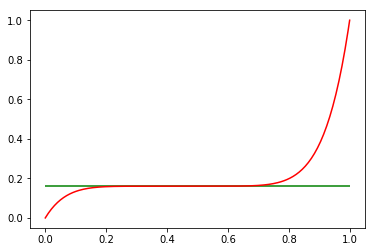

----------------------
(2, 200, 1)


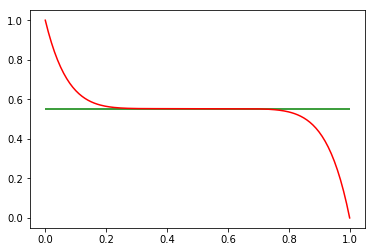

----------------------
(2, 200, 1)


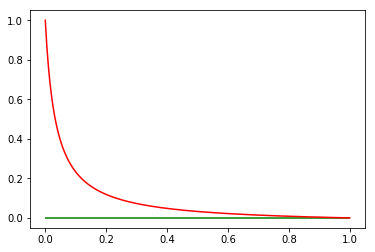

----------------------
(2, 200, 1)


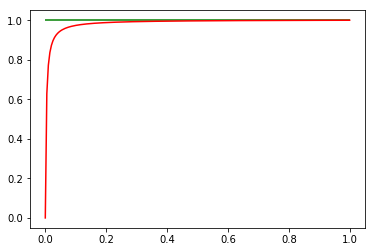

----------------------
(2, 200, 1)


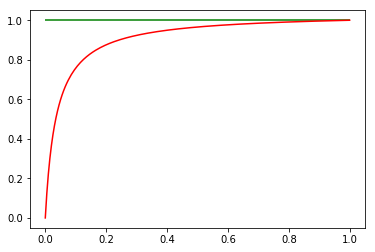

----------------------
(2, 200, 1)


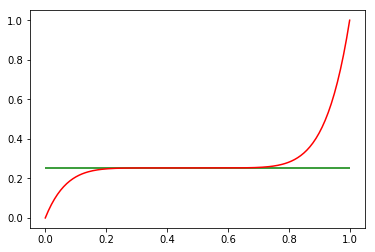

----------------------
(2, 200, 1)


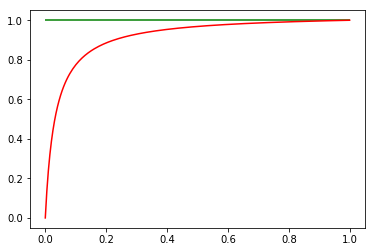

----------------------
(2, 200, 1)


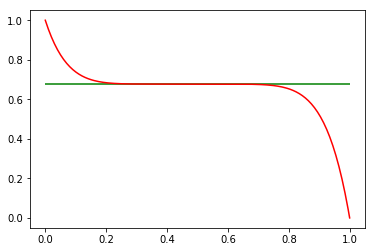

----------------------
(2, 200, 1)


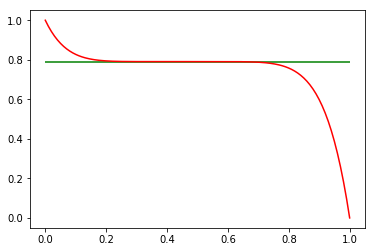

----------------------
(2, 200, 1)


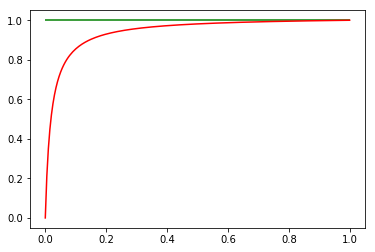

----------------------


In [558]:
for i in range(10):
    btch = (load_ppl << ds).next_batch(2)
    print(btch.y.shape)
    plt.plot(btch.x[0], btch.y[0], c='r')
    plt.hlines(btch.target[0], 0, 1, colors='g')
    plt.show()
    print('----------------------')

# Сеть с 3 полносвязными слоями

In [591]:
model_config={'inputs': dict(signals={'shape': (GRID_SIZE, 1)},
                             labels={'shape': (1, ), 'name': 'targets'}),
              'body': dict(layout='fafa', units=[50, 50]),
              'head': dict(layout='fa', units=1),
              'initial_block/inputs': 'signals',
              'loss': 'mse',
              'optimizer': ('MomentumOptimizer', {'learning_rate': 0.001, 'momentum': 0.5}),
             }

In [592]:
train_template = (load_ppl
                  .init_variable('loss', init_on_each_run=0)
                  .init_model('static', TFModel, 'baseline', config=model_config)
                  .train_model('baseline', fetches='loss',
                               feed_dict={'signals': B('y'),
                                          'labels': B('target')},
                               save_to=V('loss'), mode='w')
                 ) << ds

Смотрим значения лосса только на трейне, т.к данные генерятся случайно на каждом шаге, переобучиться на трейн нельзя

In [593]:
train_loss = []

In [594]:
for i in tqdm(range(500)):
    btch = train_template.next_batch(20, shuffle=True, n_epochs=None)
    train_loss.append(train_template.get_variable('loss'))

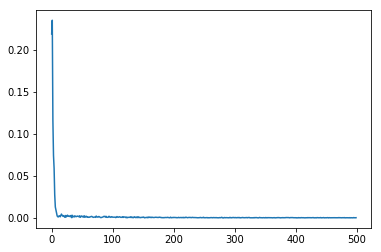

In [595]:
plt.plot(train_loss[:])

In [598]:
train_loss[-10:]

[0.0001317988,
 0.0002750402,
 0.00029426877,
 0.0001684716,
 0.00018544917,
 0.0004581657,
 0.00020280997,
 0.00035448643,
 0.00020657876,
 0.00030252413]

Ура, действительно обучается! 

# Рассмотрим сверточную сеть

In [618]:
model_config={'inputs': dict(signals={'shape': (GRID_SIZE, 1)},
                             labels={'shape': (1, ), 'name': 'targets'}),
              'body': dict(layout='cnacna', filters=[20, 40], kernel_size=[20, 10]),
              'head': dict(layout='fa', units=1),
              'initial_block/inputs': 'signals',
              'loss': 'mse',
              'optimizer': ('MomentumOptimizer', {'learning_rate': 0.001, 'momentum': 0.9}),
             }

In [622]:
train_template = (load_ppl
                  .init_variable('loss', init_on_each_run=0)
                  .init_model('static', TFModel, 'baseline', config=model_config)
                  .train_model('baseline', fetches='loss',
                               feed_dict={'signals': B('y'),
                                          'labels': B('target')},
                               save_to=V('loss'), mode='w')
                 ) << ds

In [623]:
train_loss = []

for i in tqdm(range(500)):
    btch = train_template.next_batch(20, shuffle=True, n_epochs=None)
    train_loss.append(train_template.get_variable('loss'))


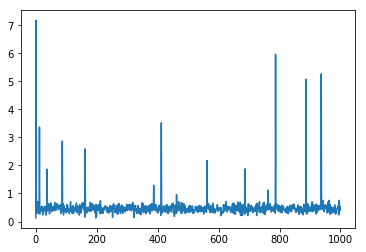

In [605]:
plt.plot(train_loss[:]) # loss c kernel_size=3

# Знакомая картина! что происходит??

Заметим, что дефолтное значение kernel_size=3 - в нашем случае не самый лучший вариант

Обучились при kernel_size=20

In [631]:
model_config={'inputs': dict(signals={'shape': (GRID_SIZE, 1)},
                             labels={'shape': (1, ), 'name': 'targets'}),
              'body': dict(layout='cnacna', filters=[20, 40], kernel_size=[20, 20]),
              'head': dict(layout='fa', units=1),
              'initial_block/inputs': 'signals',
              'loss': 'mse',
              'optimizer': 'Adam',
             }

In [632]:
train_template = (load_ppl
                  .init_variable('loss', init_on_each_run=0)
                  .init_model('static', TFModel, 'baseline', config=model_config)
                  .train_model('baseline', fetches='loss',
                               feed_dict={'signals': B('y'),
                                          'labels': B('target')},
                               save_to=V('loss'), mode='w')
                 ) << ds

In [633]:
train_loss = []

for i in tqdm(range(500)):
    btch = train_template.next_batch(20, shuffle=True, n_epochs=None)
    train_loss.append(train_template.get_variable('loss'))


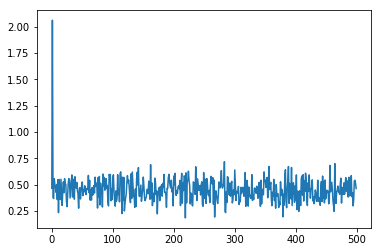

In [630]:
plt.plot(train_loss[:])

Это случайный график, я чуть было не подпрыгнула! но на самом деле, все выгляит вот так

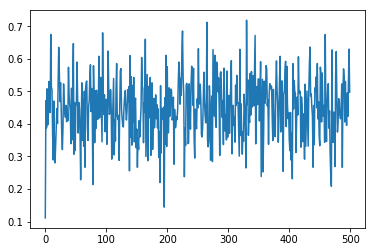

In [635]:
plt.plot(train_loss[:])

По крайней мере, больше нет относительно гигантских выбросов, но мы не обучаемся.

In [ ]:
train_loss = []

for i in tqdm(range(5000)):
    btch = train_template.next_batch(20, shuffle=True, n_epochs=None)
    train_loss.append(train_template.get_variable('loss'))
